In [100]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
#nltk.download('wordnet')
from nltk.stem import PorterStemmer
from tqdm import tqdm

In [101]:
#import spacy

In [102]:
personas_data = pickle.load(open("Data/characters_personas_data.pickle", "rb")) # SHOULD BE IN FOLDER PICKLE SO TO MODIFY!

FileNotFoundError: [Errno 2] No such file or directory: 'Data/characters_personas_data.pickle'

In [ ]:
display(personas_data)

In [ ]:
# we drop the characters that have no words associated to them -  they do not appear in summaries
personas_noNA = personas_data.dropna(subset="Chunks")
display(personas_noNA)

In [ ]:
# Check the type of the first element in each column to make sure they were saved properly
first_verb = type(personas_noNA['Verbs'][0])
first_noun = type(personas_noNA['Nouns'][0])
first_adjective = type(personas_noNA['Adjectives'][0])

print(f'Type of the first element in Verbs column: {first_verb}')
print(f'Type of the first element in Nouns column: {first_noun}')
print(f'Type of the first element in Adjectives column: {first_adjective}')

In [ ]:
# create a column "decade" to do the analysis on decades and not years
final_personas_df = personas_noNA.copy()
final_personas_df['decade'] = final_personas_df['release_date'] // 10 * 10
display(final_personas_df)

In [ ]:
final_personas_df_perso = final_personas_df.dropna(subset="personnas")
display(final_personas_df_perso)

In [ ]:
# sort the rows to have decades in ascending orders
final_personas_df = final_personas_df.sort_values(by='decade')

In [ ]:
import ast
movie_data=pd.read_csv("data/movie_data_final.csv")
movie_data['genre'] = movie_data['genre'].apply(ast.literal_eval)
movie_data
final_personas_df = final_personas_df.merge(movie_data[['IMDB_ID', 'genre']], on='IMDB_ID', how='left')
final_personas_df

In [ ]:
unique_decades = final_personas_df['decade'].unique() # control the order of the decades
print(unique_decades)

In [ ]:
# group the movies by decade
personas_by_decade = final_personas_df.groupby(final_personas_df['decade'])
count_per_decade = personas_by_decade.size() # to have the number of characters per decade

plt.figure(figsize=(10, 6))
count_per_decade.plot(kind='line', color='skyblue', marker='o')
plt.title('Number of Character per Decade in the Dataset')
plt.xlabel('Decade')
plt.ylabel('Number of Characters')
plt.grid(True)
plt.show()

There is a fairly huge number of character per decade since 1930 so the later analysis should be reliable. However, the number of characters in 1910s' as well as 1920s' is low so these 2 decades might not have results that accurately represent reality.

In [ ]:
result_df = final_personas_df[final_personas_df.apply(lambda row: 'pregnant' in row['Verbs'] or 'pregnant' in row['Adjectives'] or 'pregnant' in row['Nouns'], axis=1)]

# Display the result
display(result_df)

In [ ]:
# Function to apply stemming to a list of words with a progress bar
def stem_words_with_progress(word_list):
    stemmer = PorterStemmer()
    stemmed_words = []
    for word in word_list:
        stemmed_words.append(stemmer.stem(word))
    return stemmed_words

In [ ]:
# MAX RUN THIS PLEASE :)
tqdm.pandas(desc='Stemming')
final_personas_df['Verbs'] = final_personas_df['Verbs'].progress_apply(stem_words_with_progress)
display(final_personas_df)

In [ ]:
def create_gender_dictionaries(df):
    # Initialize dictionaries for male and female characters
    male_dict = {}
    female_dict = {}

    # Iterate through the dataframe and populate dictionaries
    for index, row in df.iterrows():
        gender = row['actor_gender']
        decade = row['decade'] # we want the create a ductionnary per decade to later analyze

        # Check if the gender is male and handle empty lists (characters don't necessarily have words of the 3 cat. associated to them
        if gender == 'M':
            if decade not in male_dict:
                male_dict[decade] = {'Verbs': [], 'Adjectives': [], 'Nouns': []} # create a dict per decade

            male_dict[decade]['Verbs'].extend(row['Verbs']) if row['Verbs'] else None
            male_dict[decade]['Adjectives'].extend(row['Adjectives']) if row['Adjectives'] else None
            male_dict[decade]['Nouns'].extend(row['Nouns']) if row['Nouns'] else None

        # Check if the gender is female and handle empty lists
        elif gender == 'F':
            if decade not in female_dict:
                female_dict[decade] = {'Verbs': [], 'Adjectives': [], 'Nouns': []}

            female_dict[decade]['Verbs'].extend(row['Verbs']) if row['Verbs'] else None
            female_dict[decade]['Adjectives'].extend(row['Adjectives']) if row['Adjectives'] else None
            female_dict[decade]['Nouns'].extend(row['Nouns']) if row['Nouns'] else None

    return male_dict, female_dict


In [ ]:
male_dict, female_dict = create_gender_dictionaries(final_personas_df.sample(10000))

In [ ]:
#test function to check the dictionnaries per decade
def print_gender_dictionaries(male_dict, female_dict):
    # Print the first few elements of each decade in the male dictionary
    print("Male Dictionary:")
    for decade, values in male_dict.items():
        print(f"Decade: {decade}")
        print(f"Verbs: {values['Verbs'][:5]}")
        print(f"Adjectives: {values['Adjectives'][:5]}")
        print(f"Nouns: {values['Nouns'][:5]}")
        print()

    # Print the first few elements of each decade in the female dictionary
    print("Female Dictionary:")
    for decade, values in female_dict.items():
        print(f"Decade: {decade}")
        print(f"Verbs: {values['Verbs'][:5]}")
        print(f"Adjectives: {values['Adjectives'][:5]}")
        print(f"Nouns: {values['Nouns'][:5]}")
        print()

# Assuming df is your DataFrame
print_gender_dictionaries(male_dict, female_dict)

In [ ]:
for decade, categories in female_dict.items():
    # Accessing the frequency of "pregnant" in the 'Nouns' category for the current decade
    pregnant_frequency_Nouns = categories.get('Nouns', []).count('flattery')

    # Accessing the frequency of "pregnant" in the 'Verbs' category for the current decade
    pregnant_frequency_Verbs = categories.get('Verbs', []).count('flattery')

    # Accessing the frequency of "pregnant" in the 'Adjectives' category for the current decade
    pregnant_frequency_Adj = categories.get('Adjectives', []).count('flattery')

    print(f"Decade: {decade}")
    print("Frequency of 'flattery' in female_dict nouns:", pregnant_frequency_Nouns)
    print("Frequency of 'flattery' in female_dict verbs:", pregnant_frequency_Verbs)
    print("Frequency of 'flattery' in female_dict adj:", pregnant_frequency_Adj)
    print()


In [ ]:
def calculate_word_frequencies(dictionary):
    # Initialize a dictionary for each category (Verbs, Adjectives, Nouns)
    frequencies = {'Verbs': {}, 'Adjectives': {}, 'Nouns': {}}

    # Iterate through the dictionary and calculate word frequencies
    for category, words in dictionary.items():
        total_words = len(words)
        word_counter = Counter(words)
        frequencies[category] = {word: count / total_words for word, count in word_counter.items()}

    return frequencies

In [ ]:
from collections import Counter

def calculate_word_frequencies_bis(decades_dict):
    # Initialize a dictionary to store frequencies for each decade
    all_frequencies = {}

    # Iterate through the decades and calculate word frequencies
    for decade, dictionary in decades_dict.items():
        frequencies = {'Verbs': {}, 'Adjectives': {}, 'Nouns': {}}

        for category, words in dictionary.items():
            total_words = len(words)
            word_counter = Counter(words)
            frequencies[category] = {word: count / total_words for word, count in word_counter.items()}

        all_frequencies[decade] = frequencies

    return all_frequencies

In [ ]:
male_frequencies_per_decade = calculate_word_frequencies_bis(male_dict)
female_frequencies_per_decade = calculate_word_frequencies_bis(female_dict)

In [ ]:
male_frequencies_per_decade  = {decade: calculate_word_frequencies(dictionary) for decade, dictionary in male_dict.items()}
female_frequencies_per_decade = {decade: calculate_word_frequencies(dictionary) for decade, dictionary in female_dict.items()}

In [ ]:
def subtract_frequencies(frequencies_1, frequencies_2): # function to get relative frequencies for a word in 2 separate dictionnaries
    subtracted_frequencies = {}
    words_only_in_freq1 = set()
    words_only_in_freq2 = set()

    # Iterate through decades
    for decade in frequencies_1.keys():
        # Initialize dictionary for the current decade
        subtracted_frequencies[decade] = {'Verbs': {}, 'Adjectives': {}, 'Nouns': {}}

        # Iterate through categories (Verbs, Adjectives, Nouns)
        for category in frequencies_1[decade].keys():
            # Get the set of words in both dictionaries for the current category
            common_words = set(frequencies_1[decade][category].keys()) & set(frequencies_2[decade][category].keys())
            # Calculate the subtracted frequencies for the current category
            for word in common_words:
                freq_1 = frequencies_1[decade][category].get(word, 0)
                freq_2 = frequencies_2[decade][category].get(word, 0)
                subtracted_frequencies[decade][category][word] = freq_1 - freq_2

            # Add the remaining words (present in one dictionary but not the other) with a frequency of 0
            remaining_words_1 = set(frequencies_1[decade][category].keys()) - common_words # words only in freq_1
            remaining_words_2 = set(frequencies_2[decade][category].keys()) - common_words # words only in freq_2
           
            
            words_only_in_freq1.update(remaining_words_1)
            words_only_in_freq2.update(remaining_words_2)

            for word in remaining_words_1:
                subtracted_frequencies[decade][category][word] = frequencies_1[decade][category][word] # assign the freq of freq_1 to that word

            for word in remaining_words_2:
                subtracted_frequencies[decade][category][word] = -frequencies_2[decade][category][word]
                
    return subtracted_frequencies, words_only_in_freq1, words_only_in_freq2


In [ ]:
def subtract_frequencies_bis(frequencies_1, frequencies_2): 
    subtracted_frequencies = {}
    words_only_in_freq1 = {}
    words_only_in_freq2 = {}

    for decade in frequencies_1.keys():
        subtracted_frequencies[decade] = {'Verbs': {}, 'Adjectives': {}, 'Nouns': {}}
        words_only_in_freq1[decade] = {'Verbs': {}, 'Adjectives': {}, 'Nouns': {}}
        words_only_in_freq2[decade] = {'Verbs': {}, 'Adjectives': {}, 'Nouns': {}}

        for category in frequencies_1[decade].keys():
            common_words = set(frequencies_1[decade][category].keys()) & set(frequencies_2[decade][category].keys())

            for word in common_words:
                freq_1 = frequencies_1[decade][category].get(word, 0)
                freq_2 = frequencies_2[decade][category].get(word, 0)
                subtracted_frequencies[decade][category][word] = freq_1 - freq_2

            remaining_words_1 = set(frequencies_1[decade][category].keys()) - common_words
            remaining_words_2 = set(frequencies_2[decade][category].keys()) - common_words

            for word in remaining_words_1:
                subtracted_frequencies[decade][category][word] = frequencies_1[decade][category][word]
                words_only_in_freq1[decade][category][word] = frequencies_1[decade][category][word]

            for word in remaining_words_2:
                subtracted_frequencies[decade][category][word] = -frequencies_2[decade][category][word]
                words_only_in_freq2[decade][category][word] = frequencies_2[decade][category][word]

    return subtracted_frequencies, words_only_in_freq1, words_only_in_freq2

In [ ]:
relative_frequencies, unique_male, unique_female = subtract_frequencies_bis(male_frequencies_per_decade, female_frequencies_per_decade)

In [ ]:
total_words = 0
for decade, categories in relative_frequencies.items():
    for category, words in categories.items():
        total_words += len(words)
        
total_words_M = 0
for decade, categories in unique_male.items():
    for category, words in categories.items():
        total_words_M += len(words)
        
total_words_F = 0
for decade, categories in unique_female.items():
    for category, words in categories.items():
        total_words_F += len(words)
        
print("The total number of words is:", total_words)
print(total_words_M, " words are solely associated to men, representing ",100*total_words_M/total_words, "% of the total number of words")
print(total_words_F, " words are solely associated to women, representing ",100*total_words_F/total_words, "% of the total number of words")

In [111]:
def plot_rel_freq_per_decade(relative_frequencies, categories):
    # Create subplots for each category
    decades = relative_frequencies.keys()
    num_categories = len(categories)

    fig, axs = plt.subplots(len(decades), num_categories, figsize=(5 * num_categories, 3 * len(decades)))

    # Iterate through each decade
    for i, decade in enumerate(decades):
        for j, category in enumerate(categories):
            # Get the top words and their frequencies
            top_words_positive = [word for _, word in sorted(
                zip(relative_frequencies[decade][category].values(), relative_frequencies[decade][category].keys()),
                key=lambda x: x[0],
                reverse=True
            )[:5]]

            top_words_negative = [word for _, word in sorted(
                zip(relative_frequencies[decade][category].values(), relative_frequencies[decade][category].keys()),
                key=lambda x: x[0]
            )[:5]]

            top_words = top_words_positive + top_words_negative
            top_frequencies = [relative_frequencies[decade][category][word] for word in top_words]

            # Plot the bar chart for each category
            bars = axs[i, j].bar(top_words, top_frequencies, color=['skyblue' if freq >= 0 else 'pink' for freq in top_frequencies])
            axs[i, j].set_title(f'{category} {decade}')
            axs[i, j].set_ylabel('Relative frequencies: Male - Female')

            # Rotate x-axis tick labels
            axs[i, j].set_xticklabels(top_words, rotation=45, ha='right')

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

/var/folders/my/4hvdfxj10f94l0xh5rd30q_h0000gn/T/ipykernel_5222/1560950429.py:32: UserWarning:

FixedFormatter should only be used together with FixedLocator



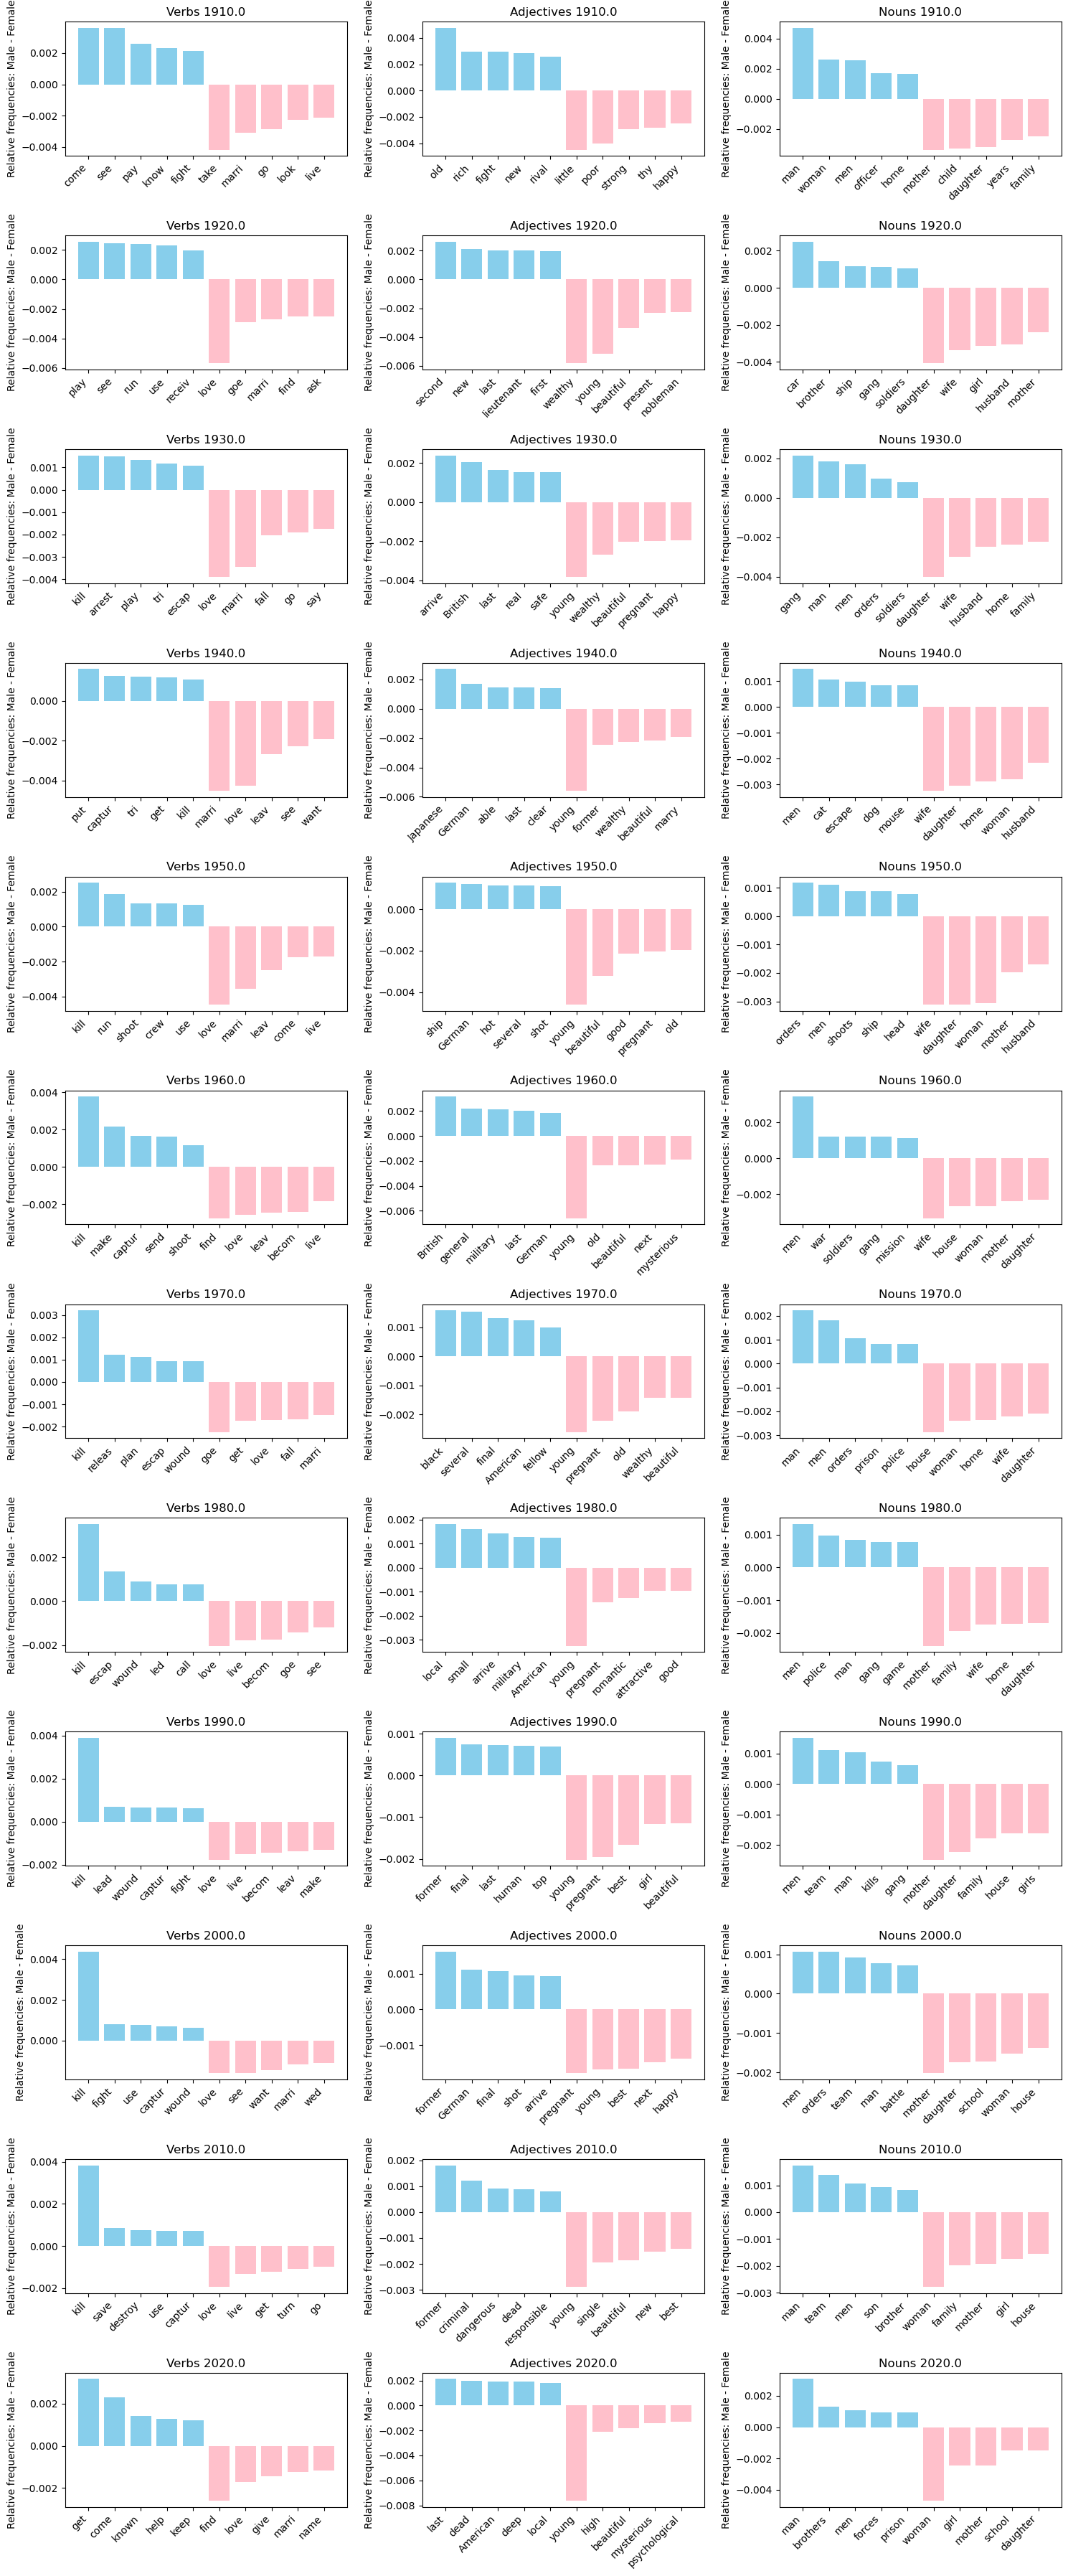

In [112]:
categories_to_plot = ['Verbs', 'Adjectives', 'Nouns']
plot_rel_freq_per_decade(relative_frequencies, categories_to_plot)

In [ ]:
categories_to_plot = ['Verbs', 'Adjectives', 'Nouns']
plot_rel_freq_per_decade_interactive(relative_frequencies, categories_to_plot)

## to do list:
- stemming on verbs 
- display words associated to unisex per decade (with top frequencies)

In [ ]:
def plot_top_words_per_decade(frequencies, categories, col = "blue"):
    # Create subplots for each category
    decades = frequencies.keys()
    num_categories = len(categories)

    fig, axs = plt.subplots(len(decades), num_categories, figsize=(5 * num_categories, 3 * len(decades)))

    # Iterate through each decade
    for i, decade in enumerate(decades):
        for j, category in enumerate(categories):
            # Get the top words and their frequencies
            top_words = [word for _, word in sorted(
                zip(frequencies[decade][category].values(), frequencies[decade][category].keys()),
                key=lambda x: x[0],
                reverse=True
            )[:5]]

            top_frequencies = [frequencies[decade][category][word] for word in top_words]

            # Plot the bar chart for each category
            bars = axs[i, j].bar(top_words, top_frequencies, color=col)
            axs[i, j].set_title(f'{category} {decade}')
            axs[i, j].set_ylabel('Absolute Frequency Difference')

            # Rotate x-axis tick labels
            axs[i, j].set_xticklabels(top_words, rotation=45, ha='right')

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

In [ ]:
categories_to_plot = ['Verbs', 'Adjectives', 'Nouns']
plot_top_words_per_decade(unique_male, categories_to_plot, "skyblue")

In [ ]:
plot_top_words_per_decade(unique_female, categories_to_plot, "pink")

In [103]:
# Assuming df is your DataFrame and 'desired_genre' is the genre you want to filter by
desired_genre = 'Action'

# Filter rows where the 'genre' column is a list and contains the desired genre
df_subset_genre = final_personas_df[final_personas_df['genre'].str.len() > 0]
df_subset_genre = df_subset_genre[df_subset_genre['genre'].apply(lambda x: desired_genre in x)]
df_subset_genre

,character_ID,wikipedia_ID,freebase_ID,actor_ethnicity,actor_name,personnas,IMDB_ID,character_name,actor_gender,box_office_revenue,name,release_date,actor_age,Verbs,Adjectives,Nouns,Chunks,decade,genre
69,33746,13495023.0,/m/03c7653,NaN,harry carey,NaN,tt0008551,Cheyenne Harry,M,NaN,The Secret Man,1917.0,39.0,"[escap, escap]",[],"[jail, jail, lies]","[[(Harry, NNP)], (escapes, VBZ), (jail, NN), [...",1910.0,"[Western, Indie, Spy, Action, Mystery]"
115,232177,NaN,NaN,NaN,gladden james,NaN,tt0008355,Dick Annersley,M,NaN,The Mystery of the Double Cross,1917.0,29.0,"[occupi, sight, arriv, lose, marri, init, over...","[mysterious, panic, double, else, gangster, so...","[woman, submarine, shoulder, ship, cross, arm,...","[(mysterious, JJ), (woman, NN), (occupying, VB...",1910.0,[Action]
134,232174,NaN,NaN,NaN,robert brower,NaN,tt0008355,Herbert Brewster,M,NaN,The Mystery of the Double Cross,1917.0,67.0,"[return, sight, thrown, ensu, shoulder, lose, ...","[panic, mysterious, mysterious, ship, else, in...","[woman, woman, action, sees, arrives, woman, w...","[[(Hale, NNP)], (returning, VBG), [(America, N...",1910.0,[Action]
135,232175,NaN,NaN,NaN,mollie king,NaN,tt0008355,Philippa Brewster,F,NaN,The Mystery of the Double Cross,1917.0,19.0,"[return, sight, ship, arriv, lose, arriv, lose...","[panic, mysterious, reveal, else, init, gangst...","[woman, arm, shoulder, shoulder, ship, woman, ...","[[(Hale, NNP)], (returning, VBG), [(America, N...",1910.0,[Action]
139,232176,NaN,NaN,NaN,ralph stuart,NaN,tt0008355,Bridgey Bentley,M,NaN,The Mystery of the Double Cross,1917.0,27.0,"[return, receiv, sight, thrown, arriv, lose, t...","[receive, telegram, panic, mysterious, double,...","[steamship, inheritance, warning, woman, cross...","[[(Hale, NNP)], (returning, VBG), [(America, N...",1910.0,[Action]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162679,135864,27645415.0,/m/0gy9d9j,NaN,lauren shiohama,NaN,tt1117581,Kawaii,F,NaN,Arena,2011.0,29.0,"[search, fight, kill, defeat, apolog, escort]","[doubtful, next]","[shut, operation, fireman, sexy, assistants, e...","[(searching, VBG), (shut, NN), (operation, NN)...",2010.0,"[Action, Thriller]"
162697,135860,27645415.0,/m/0gy9d9j,NaN,irene choi,NaN,tt1117581,Kaneko,F,NaN,Arena,2011.0,NaN,"[offer, milla, arrang, releas, believ, fight, ...","[sexy, doubtful, tenth, final, final, sex, pen...","[assistants, executioner, assistants, executio...","[(two, CD), (sexy, JJ), (assistants, NNS), [(K...",2010.0,"[Action, Thriller]"
162699,276939,NaN,NaN,NaN,perry d'marco,NaN,tt1352388,Father Carlittos,M,NaN,Nude Nuns with Big Guns,2010.0,52.0,"[corrupt, drug, abus, hire, hire, hire]","[clergy, wounded]","[verge, kill, response, church, response, chur...","[(corrupted, VBN), (clergy, JJ), (verge, NN), ...",2010.0,"[Indie, Action, Thriller]"
162728,135858,27645415.0,/m/0gy9d9j,NaN,johnny messner,NaN,tt1117581,Kaden,M,NaN,Arena,2011.0,41.0,"[featur, fight, includ, get, incapacit, allow,...","[controversial, illegal, arena, modern, Japane...","[day, gladiator, day, gladiator, combatants, d...","[(controversial, JJ), (illegal, JJ), (featurin...",2010.0,"[Action, Thriller]"


In [104]:
def subset_df(df):
    genre='Western'
    df_subset_genre = df[df['genre'].str.len() > 0]
    df_subset_genre = df_subset_genre[df_subset_genre['genre'].apply(lambda x: genre in x)]
    return df_subset_genre

In [105]:
subset_action = subset_df(final_personas_df)

In [106]:
def plot_by_genre(genre,df):
    df_subset_genre=subset_df(df)
    male_dict_genre,female_dict_genre=create_gender_dictionaries(df_subset_genre)
    male_frequencies_per_decade_genre  = {decade: calculate_word_frequencies(male_dict_genre) for decade, dictionary in male_dict_genre.items()}
    female_frequencies_per_decade_genre = {decade: calculate_word_frequencies(female_dict_genre) for decade, dictionary in female_dict_genre.items()}
    relative_frequencies_genre, unique_male_genre, unique_female_genre = subtract_frequencies(male_frequencies_per_decade_genre, female_frequencies_per_decade_genre)
    plot_rel_freq_per_decade(relative_frequencies_genre, ['Verbs', 'Adjectives', 'Nouns'])

In [107]:
male_dict_genre,female_dict_genre=create_gender_dictionaries(subset_action)
male_frequencies_per_decade_genre  = calculate_word_frequencies_bis(male_dict_genre)

NameError: name 'calculate_word_frequencies_bis' is not defined

In [ ]:
female_frequencies_per_decade_genre  = calculate_word_frequencies_bis(female_dict_genre)

In [ ]:
relative_frequencies_genre, unique_male_genre, unique_female_genre = subtract_frequencies_bis(male_frequencies_per_decade_genre, female_frequencies_per_decade_genre)
plot_rel_freq_per_decade(relative_frequencies_genre, ['Verbs', 'Adjectives', 'Nouns'])

In [ ]:
genres_to_analyze = ['Action', 'Adventure', 'Thriller', 'Drama', 'Comedy', 'Science Fiction', 'Western', 'Family Film', 'Fantasy', 'Spy', 'Sports', 'Splapstick', 'Superhero', 'Romantic comedy']
#genres_to_analyze = ['Splapstick']


# Create an empty dictionary to store data for each genre
genre_data = {}

# Iterate through genres
for genre in genres_to_analyze:
    genre_df = final_personas_df[final_personas_df['genre'].str.len() > 0]
    genre_df = genre_df[genre_df['genre'].apply(lambda x: genre in x)]

    # Group the movies by decade
    genres_by_decade = genre_df.groupby(genre_df['decade'])
    count_per_decade = genres_by_decade.size()  # Number of characters per decade

    # Store data for each genre in the dictionary
    genre_data[genre] = count_per_decade

# Plot all genres on the same plot
plt.figure(figsize=(10, 6))
for genre, data in genre_data.items():
    data.plot(kind='line', marker='o', label=genre)

plt.title('Number of Characters per Decade in the Dataset')
plt.xlabel('Decade')
plt.ylabel('Number of Characters')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

genres_to_analyze = ['Action', 'Adventure', 'Thriller', 'Drama', 'Comedy', 'Science Fiction', 'Western', 'Family Film', 'Fantasy', 'Spy', 'Sports', 'Splaptick', 'Superhero', 'Romantic comedy']

# Define your own list of colors
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta', 'yellow', 'black', 'indigo']

# Create an empty dictionary to store data for each genre
genre_data = {}

# Iterate through genres
for i, genre in enumerate(genres_to_analyze):
    genre_df = final_personas_df[final_personas_df['genre'].str.len() > 0]
    genre_df = genre_df[genre_df['genre'].apply(lambda x: genre in x)]

    # Group the movies by decade
    genres_by_decade = genre_df.groupby(genre_df['decade'])
    personas_by_decade = final_personas_df.groupby(final_personas_df['decade'])    
    # normalize by the number of character per decade
    count_per_decade_genre = genres_by_decade.size()  # Number of characters per decade
    count_per_decade = personas_by_decade.size()
    # Store data for each genre in the dictionary
    genre_data[genre] = count_per_decade_genre/count_per_decade

# Plot all genres on the same plot with manually specified colors
plt.figure(figsize=(10, 6))
for i, (genre, data) in enumerate(genre_data.items()):
    color = colors[i]
    data.plot(kind='line', marker='o', label=genre, color=color)

plt.title('Number of Characters per Decade in the Dataset')
plt.xlabel('Decade')
plt.ylabel('Number of Characters')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
for genre, data in genre_data.items():
    genre_data[genre] = data.dropna()
genre_data

In [ ]:
# Filter out genres with at least a decade with values less than 0.05
threshold = 0.05
genres_to_remove = []

for genre, values in genre_data.items():
    if (values < threshold).any():
        genres_to_remove.append(genre)

# Now, remove the genres that meet the criteria
for genre in genres_to_remove:
    del genre_data[genre]


In [ ]:
# Plot the filtered genres on the same plot with manually specified colors
plt.figure(figsize=(10, 6))
for i, (genre, data) in enumerate(genre_data.items()):
    color = colors[i]
    data.plot(kind='line', marker='o', label=genre, color=color)

plt.title('Number of Characters per Decade in the Dataset (Filtered)')
plt.xlabel('Decade')
plt.ylabel('Number of Characters')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'genre_data' is not defined

<Figure size 1000x600 with 0 Axes>

In [ ]:
genre_data['Adventure'][1910]

In [ ]:
genre_data.items()

In [242]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_rel_freq_per_decade_interactive(relative_frequencies, categories):
    # Create subplots for each category
    decades = sorted(relative_frequencies.keys())
    num_categories = len(categories)

    # Set up the initial decade
    initial_decade = decades[0]

    # Create subplots
    fig = make_subplots(rows=1, cols=num_categories, subplot_titles=[f"{category} {initial_decade}" for category in categories])

    def update_plot(decade, fig, relative_frequencies, categories):
        print(f"Updating plot for Decade: {decade}")

        # Clear existing traces
        fig.data = []

        for j, category in enumerate(categories):
            top_words_positive = [word for _, word in sorted(
                zip(relative_frequencies[decade][category].values(), relative_frequencies[decade][category].keys()),
                key=lambda x: x[0],
                reverse=True
            )[:5]]

            top_words_negative = [word for _, word in sorted(
                zip(relative_frequencies[decade][category].values(), relative_frequencies[decade][category].keys()),
                key=lambda x: x[0]
            )[:5]]

            top_words = top_words_positive + top_words_negative
            top_frequencies = [relative_frequencies[decade][category][word] for word in top_words]

            # Add new bar chart trace
            fig.add_trace(
                go.Bar(x=top_words, y=top_frequencies, marker=dict(color=['skyblue' if freq >= 0 else 'pink' for freq in top_frequencies])),
                row=1, col=j+1
            )

        # Update subplot title
        fig.update_layout(title_text=f"Decade {decade}", showlegend=False)

        print("Plot updated successfully.")

    # Initial plot
    update_plot(initial_decade, fig, relative_frequencies, categories)

    # Create slider for changing decades
    slider_steps = [
        dict(
            label=str(decade),
            method="relayout",
            args=[{"xaxis.range[0]": decade, "xaxis.range[1]": decade}],
            kwargs={"fig": fig, "decade": decade, "relative_frequencies": relative_frequencies, "categories": categories},
        ) for decade in decades
    ]

    # Set up layout with initial decade and gray background
    fig.update_layout(
        sliders=[dict(
            active=0,
            steps=slider_steps,
            pad={"t": 50},
            len=0.9,
            x=0.1,
            y=0,
            transition={"duration": 300}
        )],
        plot_bgcolor='lightgray'
    )

    # Display the plot
    fig.show()

    # Export as HTML
    fig.write_html('interactive_plot.html')


In [243]:
categories_to_plot = ['Verbs', 'Adjectives', 'Nouns']
plot_rel_freq_per_decade_interactive(relative_frequencies, categories_to_plot)

Updating plot for Decade: 1910.0
Plot updated successfully.


ValueError: Invalid property specified for object of type plotly.graph_objs.layout.slider.Step: 'kwargs'

Did you mean "args"?

    Valid properties:
        args
            Sets the arguments values to be passed to the Plotly
            method set in `method` on slide.
        execute
            When true, the API method is executed. When false, all
            other behaviors are the same and command execution is
            skipped. This may be useful when hooking into, for
            example, the `plotly_sliderchange` method and executing
            the API command manually without losing the benefit of
            the slider automatically binding to the state of the
            plot through the specification of `method` and `args`.
        label
            Sets the text label to appear on the slider
        method
            Sets the Plotly method to be called when the slider
            value is changed. If the `skip` method is used, the API
            slider will function as normal but will perform no API
            calls and will not bind automatically to state updates.
            This may be used to create a component interface and
            attach to slider events manually via JavaScript.
        name
            When used in a template, named items are created in the
            output figure in addition to any items the figure
            already has in this array. You can modify these items
            in the output figure by making your own item with
            `templateitemname` matching this `name` alongside your
            modifications (including `visible: false` or `enabled:
            false` to hide it). Has no effect outside of a
            template.
        templateitemname
            Used to refer to a named item in this array in the
            template. Named items from the template will be created
            even without a matching item in the input figure, but
            you can modify one by making an item with
            `templateitemname` matching its `name`, alongside your
            modifications (including `visible: false` or `enabled:
            false` to hide it). If there is no template or no
            matching item, this item will be hidden unless you
            explicitly show it with `visible: true`.
        value
            Sets the value of the slider step, used to refer to the
            step programatically. Defaults to the slider label if
            not provided.
        visible
            Determines whether or not this step is included in the
            slider.
        
Did you mean "args"?

Bad property path:
kwargs
^^^^^^

In [224]:
def top_freq(relative_frequencies, categories):
    # Create subplots for each category
    decades = relative_frequencies.keys()
    num_categories = len(categories)
    top_frequencies_list=[]

    # Iterate through each decade
    for i, decade in enumerate(decades):
        for j, category in enumerate(categories):
            # Get the top words and their frequencies
            top_words_positive = [word for _, word in sorted(
                zip(relative_frequencies[decade][category].values(), relative_frequencies[decade][category].keys()),
                key=lambda x: x[0],
                reverse=True
            )[:5]]

            top_words_negative = [word for _, word in sorted(
                zip(relative_frequencies[decade][category].values(), relative_frequencies[decade][category].keys()),
                key=lambda x: x[0]
            )[:5]]

            top_words = top_words_positive + top_words_negative
            top_frequencies = [relative_frequencies[decade][category][word] for word in top_words]
            top_frequencies_list.append(top_frequencies)
    return top_frequencies_list

In [172]:
temp=top_freq(relative_frequencies, ['Verbs', 'Adjectives', 'Nouns'])

In [173]:
temp

[[0.0036037857714948888,
  0.003577688043184488,
  0.0025878546071811085,
  0.0022965463701782795,
  0.0021384772969371916,
  -0.004170028042970675,
  -0.003104856084566094,
  -0.0028696542029510415,
  -0.0022845020912832786,
  -0.0021098439309646857],
 [0.004768302719529351,
  0.002981823210135824,
  0.002981823210135824,
  0.002873583274396489,
  0.0025707273943477776,
  -0.004489354484709846,
  -0.004049376691056192,
  -0.0029272597940078727,
  -0.0028458581180742302,
  -0.0024986574121971484],
 [0.004705892124773389,
  0.0026220589174180972,
  0.002544130057335795,
  0.0017068777712424313,
  0.0016571861021345835,
  -0.0033603278496163805,
  -0.003270688810275233,
  -0.0032022063884031924,
  -0.0027104214110551545,
  -0.0024747625637755854],
 [0.0025605061727272263,
  0.0024669910805790157,
  0.0023999888723460145,
  0.0022922565972811077,
  0.001973705210969798,
  -0.00568214302209606,
  -0.0028986022846286263,
  -0.0026758084624025277,
  -0.0025082427561914956,
  -0.0025056792942